# Train and Test 1D Convolutional Neural Network for GNSS

Author: Christopher Liu, 9/26/2021

In [1]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sift_conv1dnet as sconv
from torch.utils.data import TensorDataset, DataLoader 
import matplotlib.pyplot as plt

## Load Data

In [2]:
# Time window

# Load fq data
npyd = 'npy'
eta = np.load(os.path.join(npyd,'gnss_eta_z.npy'))

# Load inversions
fq_wts = np.load(os.path.join(npyd,'fq_yong_inv_best.npy'))

# Split into train, validation,  and test sets
inddir = 'indices'

train_ind = np.loadtxt(os.path.join(inddir,'fq_dart_train_index.txt')).astype(int)
train_runs= np.loadtxt(os.path.join(inddir,'fq_dart_train_runs.txt')).astype(int)

test_ind = np.loadtxt(os.path.join(inddir,'fq_dart_test_index.txt')).astype(int)
test_runs= np.loadtxt(os.path.join(inddir,'fq_dart_test_runs.txt')).astype(int)

valid_ind = np.loadtxt(os.path.join(inddir,'fq_dart_valid_index.txt')).astype(int)
valid_runs= np.loadtxt(os.path.join(inddir,'fq_dart_valid_runs.txt')).astype(int)

eta_tr = eta[train_runs, :, :]
target_tr = fq_wts[train_ind,:]

eta_ts = eta[test_runs, :, :]
target_ts = fq_wts[test_ind,:]

eta_v = eta[valid_runs, :, :]
target_v = fq_wts[valid_ind,:]

# Convert to tensors. Will need to redo if i want to keep track of run numbers...

batch = 20
shuf = False

train_x = torch.Tensor(eta_tr)
train_y = torch.Tensor(target_tr)

test_x = torch.Tensor(eta_ts)
test_y = torch.Tensor(target_ts)

valid_x = torch.Tensor(eta_v)
valid_y = torch.Tensor(target_v)

# Using the pytorch dataloader
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
valid_dataset = TensorDataset(valid_x,valid_y)

train_dataloader = DataLoader(train_dataset, batch_size = batch, shuffle = shuf, drop_last= True)
test_dataloader = DataLoader(test_dataset, batch_size = batch, shuffle = shuf, drop_last= True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch, shuffle = shuf, drop_last= True)

In [3]:
if 0:
    plt.figure(1,figsize=(12,6))
    for r in np.arange(62):
        plt.plot(np.arange(512), eta_ts[100,r,:])

## Train

In [4]:
def valid(dataloader, model, loss_fn):
    size = len(dataloader) # number of batches
    valid_model = model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = valid_model(X)
            
            valid_loss += loss_fn(pred, y).item()
    valid_loss /= size
    
    return valid_loss

In [5]:
# Set Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Set random seed
torch.random.manual_seed(100)

# Specify model, loss function, and optimizer.
nsources = 31 # Number of unit sources used in inversion
model = sconv.Conv1DNN_GNSS_enc(62, nsources).to(device)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using cpu device


In [6]:
epochs = 300
nbatches = len(train_dataloader)
train_loss_array = np.zeros(epochs)
test_loss_array = np.zeros(epochs)
valid_loss_array = np.zeros(epochs)

for t in range(epochs):
    train_loss = 0.0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_func(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # keep track of training loss
        train_loss += loss.item()
    
    # Calculating the batch-averaged loss
    avg_train_loss = train_loss/nbatches
    avg_train_loss_nbn = valid(train_dataloader, model, loss_func)
    avg_valid_loss = valid(valid_dataloader, model, loss_func)
    avg_test_loss = valid(test_dataloader, model, loss_func)
    model.train(True) #Do i need this?
        
    # every 50 epochs, print test error. Adjust print frequency 
    # depending on epoch size
    if (t+1) % 25 == 0:
        print('Epoch: %s' % str(t+1))
        print('------')
        print(f"Avg Train loss: {avg_train_loss:>8f} \n")
        print(f"Avg Train loss w/ eval: {avg_train_loss_nbn:>8f} \n")
        print(f"Avg Validation loss: {avg_valid_loss:>8f} \n")
        print(f"Avg Test loss: {avg_test_loss:>8f} \n")
    
    train_loss_array[t] = avg_train_loss
    valid_loss_array[t] = avg_valid_loss
    test_loss_array[t] = avg_test_loss

Epoch: 25
------
Avg Train loss: 29.928365 

Avg Train loss w/ eval: 29.732175 

Avg Validation loss: 31.602758 

Avg Test loss: 29.231873 

Epoch: 50
------
Avg Train loss: 43.387690 

Avg Train loss w/ eval: 51.842757 

Avg Validation loss: 48.678936 

Avg Test loss: 43.603926 

Epoch: 75
------
Avg Train loss: 51.842757 

Avg Train loss w/ eval: 51.842757 

Avg Validation loss: 48.678936 

Avg Test loss: 43.603926 

Epoch: 100
------
Avg Train loss: 51.842757 

Avg Train loss w/ eval: 51.842757 

Avg Validation loss: 48.678936 

Avg Test loss: 43.603926 

Epoch: 125
------
Avg Train loss: 51.842757 

Avg Train loss w/ eval: 51.842757 

Avg Validation loss: 48.678936 

Avg Test loss: 43.603926 

Epoch: 150
------
Avg Train loss: 51.842757 

Avg Train loss w/ eval: 51.842757 

Avg Validation loss: 48.678936 

Avg Test loss: 43.603926 

Epoch: 175
------
Avg Train loss: 51.842757 

Avg Train loss w/ eval: 51.842757 

Avg Validation loss: 48.678936 

Avg Test loss: 43.603926 

Epoch: 20

## Plot batch-averaged MSE versus epochs

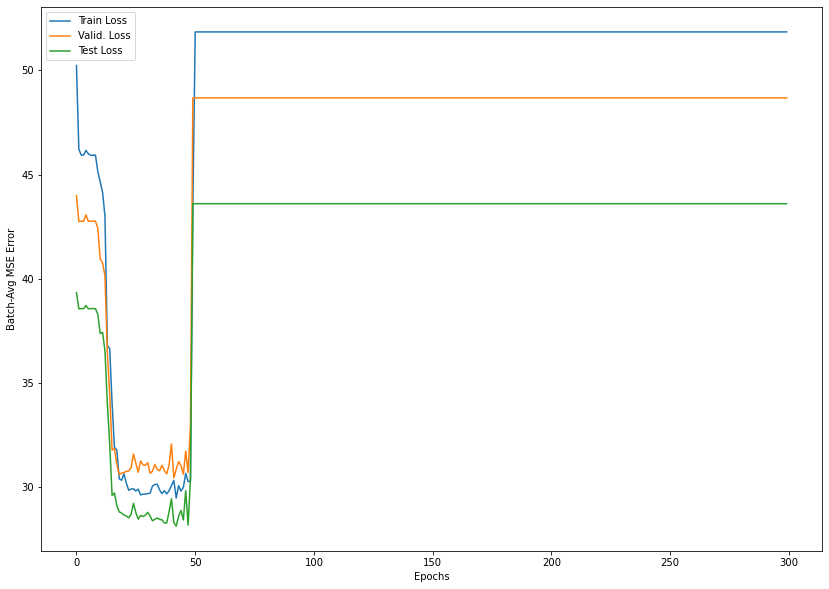

In [7]:
plt.figure(figsize=(14,10))
plt.plot(train_loss_array, label='Train Loss')
plt.plot(valid_loss_array, label='Valid. Loss')
plt.plot(test_loss_array, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Batch-Avg MSE Error')
plt.legend()
#plt.savefig('gnss_fixed_split_s100.png')

## Output results for plotting

Use model to predict test, validiation, and training data.

In [ ]:
model.eval() # important to disable dropout/batchnorm layers
with torch.no_grad():
    pred_test = model(test_x)
    pred_train = model(train_x)
    pred_valid = model(valid_x)
    print(loss_func(pred_test,test_y).item())

In [ ]:
r = 800
pred_train.detach().numpy()[r:r+20,:] - target_tr[r:r+20,:]

#### Output results as .npy

In [ ]:
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_test_180.npy'), pred_test.detach().numpy())
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_train_180.npy'), pred_train.detach().numpy())
np.save(os.path.join(npyd,'fq_conv1d_gnss_wts_valid_180.npy'), pred_valid.detach().numpy())

#### Or alternatively output as a .csv file if you wish to use MATLAB to plot results instead

In [ ]:
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_test_300.csv'),pred_test.detach().numpy(), delimiter=',')
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_train_300.csv'),pred_train.detach().numpy(), delimiter=',')
np.savetxt(os.path.join(npyd,'fq_conv1d_wts_valid_300.csv'),pred_valid.detach().numpy(), delimiter=',')

# Output the model
See https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html for more details such as loading saved models

In [ ]:
# Save the model weights and structure
torch.save(model, 'siftconv1d_model.pth')

# Save ONLY the model weights
torch.save(model.state_dict(), 'siftconv1d_model_wts.pth')

## Load Models

In [ ]:
# Loading the output with weights and structure
model_st = torch.load('siftconv1d_model.pth')
model_st.eval()

# Compare model prediction from above with prediction from the loaded model
# We expect the loss to be 0 if the model was saved and loaded correctly
print(loss_func(model_st(test_x),pred_test).item())

In [ ]:
# Loading the output with ONLY weights
model_wt = sconv.Conv1DNN(3, 31).to(device)
model_wt.load_state_dict(torch.load('siftconv1d_model_wts.pth'))
model_wt.eval()

# Compare model prediction from above with prediction from the loaded model
# We expect the loss to be 0 if the model was saved and loaded correctly
print(loss_func(model_wt(test_x),pred_test).item())